In [ ]:
# default_exp converter.core

# Model Interconversion

> API details.

In [ ]:
# hide
from nbdev.showdoc import *

In [ ]:
# export
from chitra.utility.import_utils import INSTALLED_MODULES, is_installed

In [ ]:
# export
import torch.onnx


def pytorch_to_onnx(model, tensor, export_path="temp.onnx"):
    # Input to the model
    torch_out = model(tensor)

    # Export the model
    torch.onnx.export(
        model,  # model being run
        tensor,  # model input (or a tuple for multiple inputs)
        export_path,  # where to save the model (can be a file or file-like object)
        export_params=True,  # store the trained parameter weights inside the model file
        opset_version=10,  # the ONNX version to export the model to
        do_constant_folding=True,  # whether to execute constant folding for optimization
        input_names=["input"],  # the model's input names
        output_names=["output"],  # the model's output names
        dynamic_axes={
            "input": {0: "batch_size"},  # variable length axes
            "output": {0: "batch_size"},
        },
    )
    return export_path

In [ ]:
# export
import onnx
import tf2onnx
from onnx2pytorch import ConvertModel


def onnx_to_pytorch(onnx_model):
    if isinstance(onnx_model, str):
        onnx_model = onnx.load(onnx_model)
    onnx.checker.check_model(onnx_model)
    pytorch_model = ConvertModel(onnx_model)
    return pytorch_model


def tf2_to_onnx(model, opset=None, output_path=None, **kwargs):
    inputs_as_nchw = kwargs.get("inputs_as_nchw", "input0:0")
    onnx_model = tf2onnx.convert.from_keras(
        model, opset=opset, output_path=output_path, inputs_as_nchw=inputs_as_nchw
    )
    return onnx_model


def tf2_to_pytorch(model, opset=None, **kwargs):
    with tempfile.NamedTemporaryFile(mode='w') as fw:
        filename = fw.name
        onnx_model = tf2_to_onnx(tf_model, opset, output_path=filename, **kwargs)
        fw.seek(0)
        torch_model = onnx_to_pytorch(filename)
    return torch_model

## example

In [ ]:

import numpy as np
import timm

model1 = timm.create_model("resnet18")
model1.eval()

model_inter_path = pytorch_to_onnx(model1, torch.randn(1, 3, 224, 224))
model2 = onnx_to_pytorch(model_inter_path)

x = torch.randn(1, 3, 224, 224)
np.allclose(model1(x).detach().numpy(), model2(x).detach().numpy(), 1e-4)

True

In [ ]:
import tensorflow as tf
import torch

In [ ]:
tf.__version__

'2.3.0'

In [ ]:
# tf_model = tf.keras.applications.MobileNetV2()
# model_test = tf2_to_pytorch(tf_model, inputs_as_nchw=None, opset=13).eval()

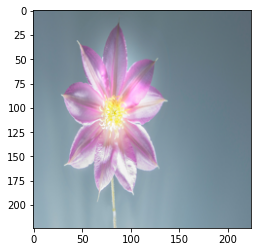

In [ ]:
import numpy as np
from chitra.image import Chitra

image = Chitra("https://c.files.bbci.co.uk/957C/production/_111686283_pic1.png")
image.image = image.image.resize((224, 224)).convert("RGB")
image.imshow()

In [ ]:
x1 = tf.cast(image.to_tensor("tf"), tf.float32) / 127.5 - 1.0
x1 = tf.expand_dims(x1, 0)

x2 = image.numpy()[:].astype(np.float32) / 255
x2 = np.expand_dims(x2, 0)
x2 = torch.from_numpy(x2)
x2 = x2.permute(0, 3, 1, 2)

In [ ]:
x2.shape

torch.Size([1, 3, 224, 224])

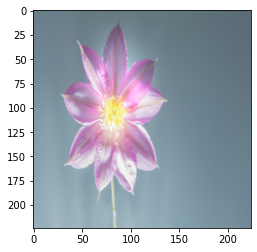

In [ ]:
Chitra(((x1[0] + 1) * 127.5).numpy().astype("uint8")).imshow()

In [ ]:
from chitra.core import IMAGENET_LABELS

res1 = tf.math.softmax(tf_model.predict(x1), 1)
IMAGENET_LABELS[tf.argmax(res1, 1).numpy()[0]]

'pinwheel'

In [ ]:
res2 = my_model(x2)
# IMAGENET_LABELS[torch.argmax(res2).item()]

RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[1, 224, 4, 225] to have 3 channels, but got 224 channels instead

In [ ]:
my_model

Sequential(
  (0): ConvertModel(
    (Conv_mobilenetv2_1.00_224/bn_Conv1/FusedBatchNormV3:0): Sequential(
      (0): ConstantPad2d(padding=[0, 1, 0, 1], value=0)
      (1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
    )
    (Clip_mobilenetv2_1.00_224/Conv1_relu/Relu6:0): clamp()
    (Conv_mobilenetv2_1.00_224/expanded_conv_depthwise_BN/FusedBatchNormV3:0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
    (Clip_mobilenetv2_1.00_224/expanded_conv_depthwise_relu/Relu6:0): clamp()
    (Conv_mobilenetv2_1.00_224/expanded_conv_project_BN/FusedBatchNormV3:0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
    (Conv_mobilenetv2_1.00_224/block_1_expand/Conv2D:0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (BatchNormalization_mobilenetv2_1.00_224/block_1_expand_BN/FusedBatchNormV3:0): BatchNormUnsafe(96, eps=0.0010000000474974513, momentum=0.1, affine=True, track_running_stats=True)
    (Clip_mobilenetv2_1.00_224/block_1_expand_re

In [ ]:
x2.shape, res2.shape

(torch.Size([1, 224, 224, 3]), torch.Size([9, 1000]))